# Lesson 4 Assignment - Automobile Price Hypothesis Testing
## Author - Yulia Zubova

### Instructions
Test hypotheses for the price of automobiles:

1. Compare and test Normality the distributions of **price** and **log price** <br/>
Use both a graphical method and a formal test. Hint: Remember these relationships will always be approximate.

2. Test significance of **price (or log price)** stratified by 
a) **fuel type**, b) **aspiration**, and c) **rear vs. front wheel drive**. <br />Use both graphical methods and the formal test.

3. Apply ANOVA and Tukey's HSD test to the auto price data to compare the **price (or log price** if closer to a Normal distribution) of autos stratified by **body style**.

4. Graphically explore the differences between the price conditioned by the categories of each variable <br/>
Hint: Make sure you have enough data for each category and drop categories with insufficient data.

5. Use standard ANOVA and Tukey HSD to test the differences of these groups.


#### Note: 
Please clearly outline the results of these tests with markdown text. Be sure your discussion includes narrative for your figures and tables so it is clear to the reader the importance of each bit of evidence.

In [28]:
# Cleaned up Dataset location
fileName = "https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/Automobile%20price%20data%20_Raw_.csv"
            #https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/Automobile%20price%20data%20_Raw_.csv

In [29]:
# Import libraries
import pandas as pd
import scipy.stats as ss
from scipy.stats import norm
import numpy.random as nr
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean
from scipy import stats
import statsmodels.stats.weightstats as ws
import statsmodels.stats.power as smsp
import numpy as np
from math import sqrt
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from operator import add
import math
from sklearn.preprocessing import scale

In [30]:
#Import dataset
auto_price = pd.read_csv(fileName)

In [36]:
#Clean rows with missing data
auto_price = auto_price.replace(to_replace="?", value=float("NaN"))
auto_price.dropna(axis = 0, inplace = True)

In [37]:
auto_price['price'] = auto_price['price'].astype(float)
#auto_price['price'] = pd.to_numeric(auto_price['price'])

In [8]:
auto_price.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159 entries, 3 to 204
Data columns (total 26 columns):
symboling            159 non-null int64
normalized-losses    159 non-null object
make                 159 non-null object
fuel-type            159 non-null object
aspiration           159 non-null object
num-of-doors         159 non-null object
body-style           159 non-null object
drive-wheels         159 non-null object
engine-location      159 non-null object
wheel-base           159 non-null float64
length               159 non-null float64
width                159 non-null float64
height               159 non-null float64
curb-weight          159 non-null int64
engine-type          159 non-null object
num-of-cylinders     159 non-null object
engine-size          159 non-null int64
fuel-system          159 non-null object
bore                 159 non-null object
stroke               159 non-null object
compression-ratio    159 non-null float64
horsepower           159 non-nul

## 1. Normality test of the distributions of price and log price 

In [40]:
#Add new column "log_price"
auto_price['log_price'] = np.log(auto_price['price'])

Null hypothesis: 
- Column 'price' has a normal distribution.
- Column 'log_price' has a normal distribution.

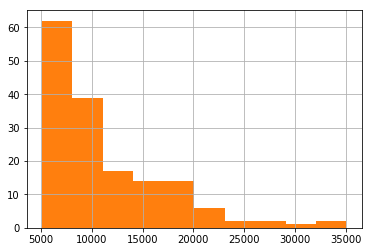

In [12]:
#Histogram of column 'price'
auto_price['price'].hist()
plt.show()

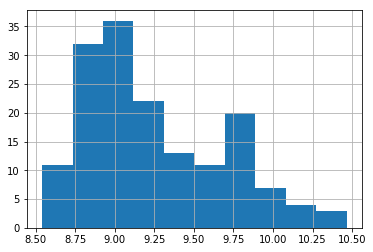

In [13]:
#Histogram of column 'log_price'
auto_price['log_price'].hist()
plt.show()

According the histograms distribution of log_price is more likely normal then distribution of price.

## Graphical method ##

For distribution test I'm going to use Q-Q plot (graphic method) and Kolmogorov-Smirnov test (formal test).

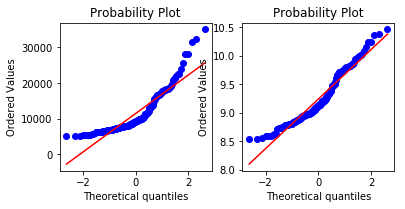

In [16]:
# Function for QQ plot building
def qq_plot(vec1, vec2):
    import matplotlib.pyplot as plt
    import scipy.stats as ss
    plt.figure(figsize=(6, 6)).gca() # define axis
    ax1 = plt.subplot(221) ## setup the left subplot
    ss.probplot(vec1, plot = ax1) ## Plot the left subplot
    ax1 = plt.subplot(222) ## Set up the right subplot
    ss.probplot(vec2, plot = ax1) ## Plot the right subplot

    
#Show QQ plot of price and log_price
qq_plot(auto_price['price'], auto_price['log_price'])   
plt.show()

If the points of the QQ plot fall on an approximately straight line, we can conclude that the sample distribution is close to the thoretical (normal in our case).
According to the plots, 'log_price' has a distribution similar to normal.

## Formal test ##

Let's perform  Kolmogorov-Smirnov test and count KS-statistics values and p-values for columns 'price' and 'log_price'.

In [17]:
price_scale = scale(auto_price['price'])
def ks_test(dat, dist = 'norm'):
    from scipy.stats import kstest 
    ks_statisic, pvalue = kstest(dat, dist)
    print('KS-statistic = ' + str(ks_statisic))
    print('P-value = ' + str(pvalue))
ks_test(price_scale)    

KS-statistic = 0.190858556056
P-value = 1.5137283208e-05


In [18]:
logprice_scale = scale(auto_price['log_price'])
def ks_test(dat, dist = 'norm'):
    from scipy.stats import kstest 
    ks_statisic, pvalue = kstest(dat, dist)
    print('KS-statistic = ' + str(ks_statisic))
    print('P-value = ' + str(pvalue))
ks_test(logprice_scale)        

KS-statistic = 0.119748225508
P-value = 0.0191546307503


For price and log_price P-value is small, so we can decline null hypotesis according this test only. 
Price and log_price don't have normal distribution (but in case with log_price p-value is not significally less than significansce level, so distribution could be close to normal, and KS-statistic is small too).

## 2. Significance test of price stratified by a) fuel type, b) aspiration, and c) rear vs. front wheel drive ##

Assume null hypotesis that difference in price means in different groups is not significant.
Test this hypotesis in groups spreaded by fuel type, aspiration and wheel-drive type (rear vs front).

For hypotesis testing will use double-sided t-test.

In [19]:
# functions, creating histograms of the two populations along with a line for the mean of each population
%matplotlib inline
def hist_plot(vec, bins):
    import matplotlib.pyplot as plt
    from statistics import mean
    plt.hist(vec, bins = bins)
    plt.axvline(mean(vec), color = 'red')
    plt.ylabel('Frequency')
    plt.xlabel('Value')
    
def plot_pop(a, b, cols=['pop_A', 'pop_B'], nbins = 20):
    import matplotlib.pyplot as plt
    minx = min([min(a), min(b)])
    maxx = max([max(a), max(b)])
    stepx = (maxx - minx)/(nbins + 1)
    bins = [minx + i * stepx for i in range(nbins + 1)]
    plt.subplot(2, 1, 1) # The first plot
    hist_plot(a, bins)
    plt.title('Histograme of ' + cols[0] + ' and ' + cols[1])
    plt.subplot(2, 1, 2) # The next plot
    hist_plot(b, bins)



In [20]:
# hystogram of population with mean ans the the upper and lower confidence bounds
def hist_mean_ci(vec, t_test, bins):
    import matplotlib.pyplot as plt
    from statistics import mean
    upper = mean(vec) + t_test[5] - t_test[1]
    lower = mean(vec) + t_test[4] - t_test[1]
    plt.hist(vec, bins = bins)
    plt.axvline(mean(vec), color = 'red')
    plt.axvline(upper, color = 'red', linestyle='--')
    plt.axvline(lower, color = 'red', linestyle='--')
    plt.ylabel('Frequency')
    plt.xlabel('Value')

def plot_t(a, b, t_test, cols=['pop_A', 'pop_B'], nbins = 20):
    import matplotlib.pyplot as plt
    minx = min([min(a), min(b)])
    maxx = max([max(a), max(b)])
    stepx = (maxx - minx)/(nbins + 1)
    bins = [minx + i * stepx for i in range(nbins + 1)]
    plt.subplot(2, 1, 1) # The first plot
    hist_mean_ci(a, t_test, bins)
    plt.title('Histogram of ' + cols[0] + ' and ' + cols[1])
    plt.subplot(2, 1, 2) # The next plot
    hist_plot(b, bins)

In [21]:
#Function, executing double-sided t-test
def t_test(a, b, alpha, alternative='two-sided'):
    from scipy import stats
    import scipy.stats as ss
    import pandas as pd
    import statsmodels.stats.weightstats as ws
    
    diff = a.mean() - b.mean()

    res = ss.ttest_ind(a, b) # generate a t-statistic from a and b 
      
    means = ws.CompareMeans(ws.DescrStatsW(a), ws.DescrStatsW(b)) # create an opbject containing both sets of data

    confint = means.tconfint_diff(alpha=alpha, alternative=alternative, usevar='unequal') # generate the confidence interval for the difference in means
    degfree = means.dof_satt() # effective degrees of freedom of Satterthwaite for unequal variance. https://en.wikipedia.org/wiki/Welch%E2%80%93Satterthwaite_equation
    
    index = ['DegFreedom', 'Difference', 'Statistic', 'PValue', 'Low95CI', 'High95CI']
    return pd.Series([degfree, diff, res[0], res[1], confint[0], confint[1]], index = index)   
   

### By fuel type ###

In [22]:
#Check amount distinct values of column 'fuel-type'
auto_price['fuel-type'].value_counts()

gas       144
diesel     15
Name: fuel-type, dtype: int64

DegFreedom       15.050468
Difference    -5238.023611
Statistic        -3.391997
PValue            0.000878
Low95CI      -10206.501896
High95CI       -269.545326
dtype: float64


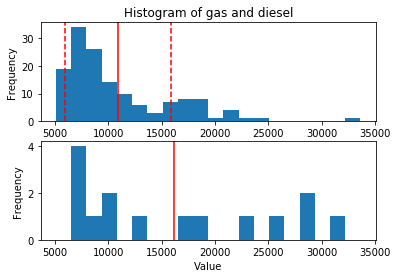

In [25]:
#samples by fuel-type
gas = auto_price.loc[auto_price.loc[:, 'fuel-type'] == 'gas', 'price']
diesel = auto_price.loc[auto_price.loc[:, 'fuel-type'] == 'diesel', 'price']

#t-test
test_fuel = t_test(gas, diesel, alpha = 0.05)
print(test_fuel)
plot_t(gas, diesel, test_fuel, cols=['gas autos', 'diesel autos'])

1. The t-statistic is large (by absolute value), the p-value is small and the confidence interval of the difference of the means does not overlap zero. We can reject the null hypothesis that the means are the same and there aren't significant differences in price for gas and diesel cars. There is a low chance that the difference is from random variation alone.
2. The mean of the second sample falls outside the confidence interval, confirming that there is a low chance that the difference is from random variation alone.

### By aspiration ### 

In [59]:
#Check amount distinct values of column 'aspiration'
auto_price['aspiration'].value_counts()

std      132
turbo     27
Name: aspiration, dtype: int64

DegFreedom    3.180572e+01
Difference   -6.760904e+03
Statistic    -6.023073e+00
PValue        1.170476e-08
Low95CI      -9.584033e+03
High95CI     -3.937775e+03
dtype: float64


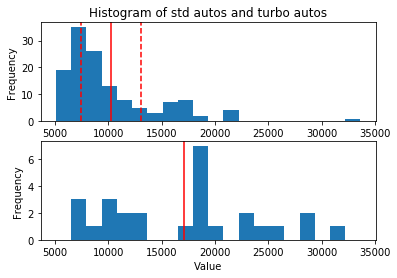

In [27]:
#Samples by aspiration
std = auto_price.loc[auto_price.loc[:, 'aspiration'] == 'std', 'price']
turbo = auto_price.loc[auto_price.loc[:, 'aspiration'] == 'turbo', 'price']

#t-test and plot
test_aspiration = t_test(std, turbo, alpha = 0.05)
print(test_aspiration)
plot_t(std, turbo, test_aspiration, cols=['std autos', 'turbo autos'])

1. The t-statistic is large (by absolute value), the p-value is small and the confidence interval of the difference of the means does not overlap zero. We can reject the null hypothesis that the means are the same and there aren't significant differences in price for standart and turbo cars. There is a low chance that the difference is from random variation alone.
2. The mean of the second sample falls outside the confidence interval, confirming that there is a low chance that the difference is from random variation alone.

### By wheel drive type

In [58]:
#Check amount distinct values of column 'drive-wheels'
auto_price['drive-wheels'].value_counts()

fwd    105
rwd     46
4wd      8
Name: drive-wheels, dtype: int64

DegFreedom    5.490245e+01
Difference    8.858179e+03
Statistic     1.143320e+01
PValue        3.965316e-22
Low95CI       6.877018e+03
High95CI      1.083934e+04
dtype: float64


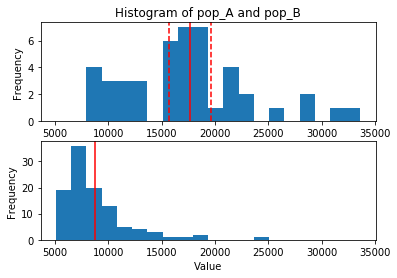

In [31]:
#Samples by drive-wheel type
rwd = auto_price.loc[auto_price.loc[:, 'drive-wheels'] == 'rwd', 'price']
fwd = auto_price.loc[auto_price.loc[:, 'drive-wheels'] == 'fwd', 'price']

#t-test and plot
test_drive = t_test(rwd, fwd, alpha = 0.05)
print(test_drive)
plot_t(rwd, fwd, test_drive, cols=['rwd autos', 'fwd autos'])

1. The t-statistic is quite large, the p-value is small and the confidence interval of the difference of the means does not overlap zero. We can reject the null hypothesis that the means are the same and there aren't significant differences in price for rwd and fwd cars. There is a low chance that the difference is from random variation alone.
2. The mean of the second sample falls outside the confidence interval, confirming that there is a low chance that the difference is from random variation alone.

## 3. ANOVA and Tukey's HSD test to compare the price (log price) of autos stratified by body style ##

Null hypotesis: all variables (log_price stratified by body-style have the same mean).

In [38]:
#Check amount distinct values of column 'body-style'
auto_price['body-style'].value_counts()

sedan          79
hatchback      56
wagon          17
hardtop         5
convertible     2
Name: body-style, dtype: int64

In [32]:
auto_price['price'].value_counts()

?        4
16500    2
18150    2
8495     2
8921     2
7295     2
6692     2
5572     2
13499    2
6229     2
7957     2
8845     2
9279     2
7775     2
7609     2
7898     2
45400    1
31600    1
14399    1
11850    1
23875    1
12764    1
34028    1
11845    1
7349     1
7603     1
5151     1
6855     1
15645    1
8949     1
        ..
13860    1
8499     1
6918     1
35550    1
15985    1
8558     1
12945    1
13495    1
5399     1
12170    1
17199    1
22470    1
24565    1
9960     1
16845    1
13200    1
11900    1
7129     1
15750    1
12629    1
16925    1
6377     1
13415    1
7689     1
8013     1
16430    1
15250    1
6295     1
21105    1
5195     1
Name: price, Length: 187, dtype: int64

In case the distribution of log_price is more likely normal, I'll use log_price in following tests.

In [41]:
#Create samples by different body-styles
sedan = auto_price.loc[auto_price.loc[:, 'body-style'] == 'sedan', 'log_price']
hatchback = auto_price.loc[auto_price.loc[:, 'body-style'] == 'hatchback', 'log_price']
wagon = auto_price.loc[auto_price.loc[:, 'body-style'] == 'wagon', 'log_price']
hardtop = auto_price.loc[auto_price.loc[:, 'body-style'] == 'hardtop', 'log_price']
convertible = auto_price.loc[auto_price.loc[:, 'body-style'] == 'convertible', 'log_price']

3       9.543235
4       9.767095
6       9.781885
8      10.080587
10      9.706864
11      9.736547
12      9.950848
13      9.957265
20      8.791030
25      8.808668
26      8.937087
35      8.894944
39      9.087608
40      9.239414
41      9.468465
42      9.244259
47     10.381273
53      8.809116
54      8.908559
60      9.047233
62      9.234545
65      9.813563
67     10.148471
70     10.360912
85      8.852093
86      9.010547
87      9.135509
88      9.135509
89      8.612322
90      8.867709
         ...    
141     8.871505
142     8.958669
143     9.206332
144     9.130539
145     9.328923
156     8.844769
158     8.974365
160     8.953899
162     9.133243
163     8.994421
165     9.137555
173     9.099185
174     9.277812
176     9.296335
180     9.660779
182     8.958669
183     8.984067
184     8.986572
185     9.011279
186     9.047233
187     9.158521
188     9.209840
194     9.468079
196     9.679406
198     9.821192
200     9.731809
201     9.854560
202     9.9751

C:\Users\zubov\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


Text(0.5,1,'Box plot by Body Style')

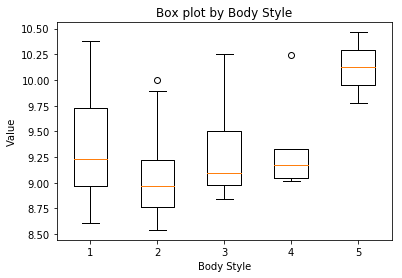

In [64]:
#Log_price boxplot by body-style
plt.boxplot([sedan, hatchback, wagon, hardtop, convertible])
plt.ylabel('Value')
plt.xlabel('Body Style')
plt.title('Box plot by Body Style')

According the boxplot, there is a significant difference in log_price between different body-styles of autos. The most significant difference probably between convertible cars and any other type of car.

In [35]:
#F-statistic and P-value for autos with different body-style  (ANOVA test)
f_statistic, p_value = ss.f_oneway(sedan, hatchback, wagon, hardtop, convertible) # fill in parameters
print('F statistic = ' + str(f_statistic))
print('P-value = ' + str(p_value))

F statistic = 6.49228766671
P-value = 7.44769402446e-05


F-statistic is big, P-value is small. There is a significant difference in price for autos stratified by body-style, so we can
reject null hypotesis. 

  Multiple Comparison of Means - Tukey HSD,FWER=0.05 
   group1     group2  meandiff  lower   upper  reject
-----------------------------------------------------
convertible  hardtop  -0.7615  -1.7188  0.1958 False 
convertible hatchback  -1.072  -1.8954 -0.2486  True 
convertible   sedan   -0.7808    -1.6   0.0385 False 
convertible   wagon   -0.8712  -1.7265 -0.0159  True 
  hardtop   hatchback -0.3105  -0.8445  0.2236 False 
  hardtop     sedan   -0.0192  -0.5469  0.5084 False 
  hardtop     wagon   -0.1097  -0.6918  0.4724 False 
 hatchback    sedan    0.2912   0.0914  0.4911  True 
 hatchback    wagon    0.2008   -0.116  0.5176 False 
   sedan      wagon   -0.0904  -0.3963  0.2155 False 
-----------------------------------------------------


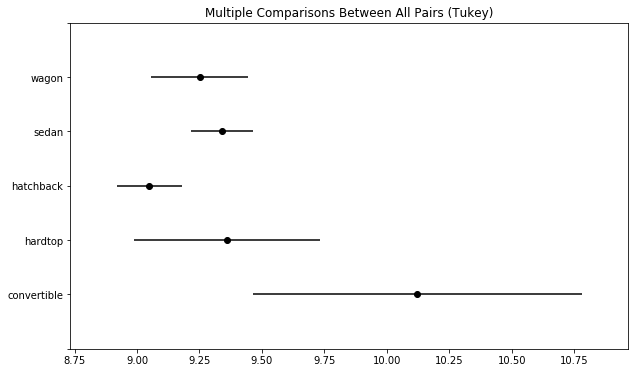

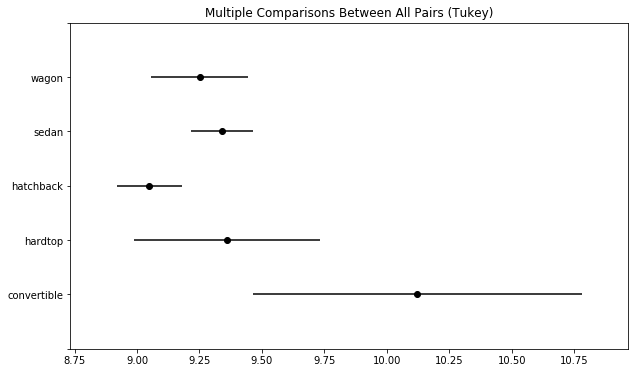

In [65]:
#Tukey test
from statsmodels.stats.multicomp import pairwise_tukeyhsd
Tukey_auto = pairwise_tukeyhsd(auto_price['log_price'], auto_price['body-style']) # fill in the parameters
print(Tukey_auto)
Tukey_auto.plot_simultaneous()

According Tukey test null hypotesis is rejected for pairs:
* convertible and hatchback;
* convertible and wagon;
* hatchback and sedan.



## 4. Differences between the price conditioned by the categories of each variable ##

In previous paragraphs we tested price (or log_price) by these categorical variables: body-style, fuel-type, aspiration, wheel drive type.
For last two tasks let's check Make, Number of Doors and Fuel System.
For graphical analisys I'm going to use boxplots.

## By Make

In [66]:
#Check amount distinct values
auto_price['make'].value_counts()

toyota           31
nissan           18
honda            13
subaru           12
volvo            11
mazda            11
mitsubishi       10
volkswagen        8
dodge             8
peugot            7
saab              6
plymouth          6
mercedes-benz     5
bmw               4
audi              4
chevrolet         3
porsche           1
jaguar            1
Name: make, dtype: int64

For following analisys I'll use only makes that are presented more then 5 times. In this case it's more likely that our sample is representative.

In [37]:
#Samples by make
toyota = auto_price.loc[auto_price.loc[:, 'make'] == 'toyota', 'log_price']
nissan = auto_price.loc[auto_price.loc[:, 'make'] == 'nissan', 'log_price']
honda = auto_price.loc[auto_price.loc[:, 'make'] == 'honda', 'log_price']
subaru = auto_price.loc[auto_price.loc[:, 'make'] == 'subaru', 'log_price']
volvo = auto_price.loc[auto_price.loc[:, 'make'] == 'volvo', 'log_price']
mazda = auto_price.loc[auto_price.loc[:, 'make'] == 'mazda', 'log_price']
mitsubishi = auto_price.loc[auto_price.loc[:, 'make'] == 'mitsubishi', 'log_price']
volkswagen = auto_price.loc[auto_price.loc[:, 'make'] == 'volkswagen', 'log_price']
dodge = auto_price.loc[auto_price.loc[:, 'make'] == 'dodge', 'log_price']
peugot = auto_price.loc[auto_price.loc[:, 'make'] == 'peugot', 'log_price']
saab = auto_price.loc[auto_price.loc[:, 'make'] == 'saab', 'log_price']
plymouth = auto_price.loc[auto_price.loc[:, 'make'] == 'plymouth', 'log_price']

C:\Users\zubov\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


Text(0.5,1,'Box plot by Make')

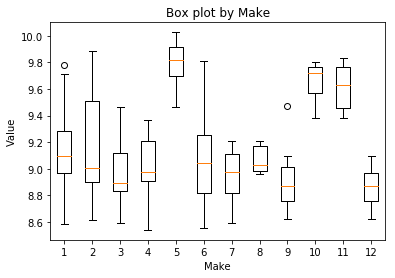

In [41]:
plt.boxplot([toyota, nissan, honda, subaru, volvo, mazda, mitsubishi, volkswagen, dodge, peugot, saab, plymouth])
plt.ylabel('Value')
plt.xlabel('Make')
plt.title('Box plot by Make')

According the boxplot, there is a significant difference in log_price for some makes of autos. The most significant difference probably between volvo and other Make.

## By Number of Doors ##

In [19]:
#Check amount distinct values
auto_price['num-of-doors'].value_counts()

four    95
two     64
Name: num-of-doors, dtype: int64

In [42]:
#Samples by number of doors
two_doors = auto_price.loc[auto_price.loc[:, 'num-of-doors'] == 'two', 'log_price']
four_doors = auto_price.loc[auto_price.loc[:, 'num-of-doors'] == 'four', 'log_price']

C:\Users\zubov\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


Text(0.5,1,'Box plot by Number of Doors')

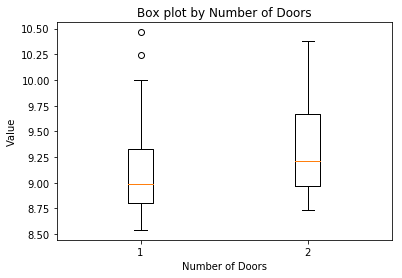

In [43]:
plt.boxplot([two_doors, four_doors])
plt.ylabel('Value')
plt.xlabel('Number of Doors')
plt.title('Box plot by Number of Doors')

On the boxplot difference by make doesn't look significant. Means are almost equal, confidence intervals overlap.

## By Fuel System ##

In [21]:
#Check amount distinct values
auto_price['fuel-system'].value_counts()

mpfi    64
2bbl    63
idi     15
1bbl    11
spdi     5
mfi      1
Name: fuel-system, dtype: int64

In [44]:
#Samples by Fuel System
mpfi = auto_price.loc[auto_price.loc[:, 'fuel-system'] == 'mpfi', 'log_price']
bbl2 = auto_price.loc[auto_price.loc[:, 'fuel-system'] == '2bbl', 'log_price']
idi = auto_price.loc[auto_price.loc[:, 'fuel-system'] == 'idi', 'log_price']
bbl1 = auto_price.loc[auto_price.loc[:, 'fuel-system'] == '1bbl', 'log_price']
spdi = auto_price.loc[auto_price.loc[:, 'fuel-system'] == 'spdi', 'log_price']

For following analisys I'll use only fuel systems that are presented 5 or more times. In this case it's more likely that our sample is representative

C:\Users\zubov\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


Text(0.5,1,'Box plot by Fuel System')

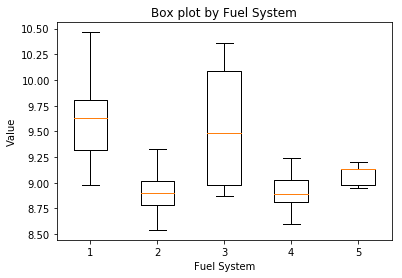

In [45]:
plt.boxplot([mpfi, bbl2, idi, bbl1, spdi])
plt.ylabel('Value')
plt.xlabel('Fuel System')
plt.title('Box plot by Fuel System')

According the boxplot, there is a significant difference in log_price for different fuel systems. 

## 5. Standard ANOVA and Tukey HSD to test the differences ##

Test differences in price (log_price in our case) performing standart Anova and Tukey HSD tests.

## By Make ##

In [46]:
#F-statistic and P-value for autos with different body-style  (ANOVA test)
f_statistic, p_value = ss.f_oneway(toyota, nissan, honda, subaru, volvo, mazda, mitsubishi, volkswagen, dodge, peugot, saab, plymouth) # fill in parameters
print('F statistic = ' + str(f_statistic))
print('P-value = ' + str(p_value))

F statistic = 11.8248370203
P-value = 4.53173919867e-15


F-statistic is big, P-value is small. There is a significant difference in price for autos stratified by make, so we can
reject null hypotesis. 

     Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower   upper  reject
-----------------------------------------------------------
     audi          bmw       0.0447  -0.6149  0.7043 False 
     audi       chevrolet    -1.098  -1.8105 -0.3856  True 
     audi         dodge     -0.8661  -1.4374 -0.2949  True 
     audi         honda     -0.8103  -1.3436 -0.2769  True 
     audi         jaguar     0.5881  -0.4549  1.631  False 
     audi         mazda     -0.7395  -1.2841 -0.1948  True 
     audi     mercedes-benz  0.5006  -0.1251  1.1264 False 
     audi       mitsubishi  -0.8469  -1.3988  -0.295  True 
     audi         nissan    -0.6198  -1.1354 -0.1042  True 
     audi         peugot    -0.1387  -0.7233  0.446  False 
     audi        plymouth   -0.9288   -1.531 -0.3267  True 
     audi        porsche     0.2064  -0.8365  1.2493 False 
     audi          saab     -0.1777  -0.7798  0.4244 False 
     audi         subaru    -0.7651  -1.

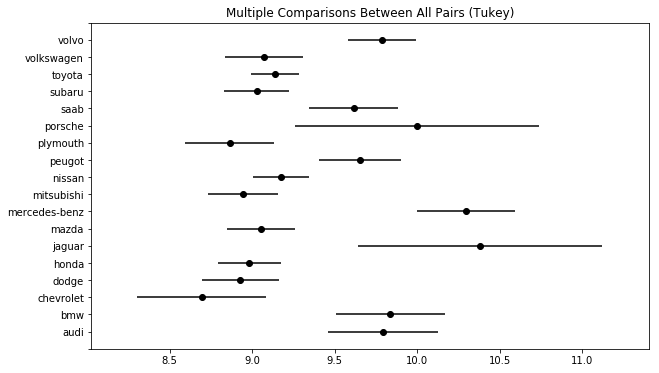

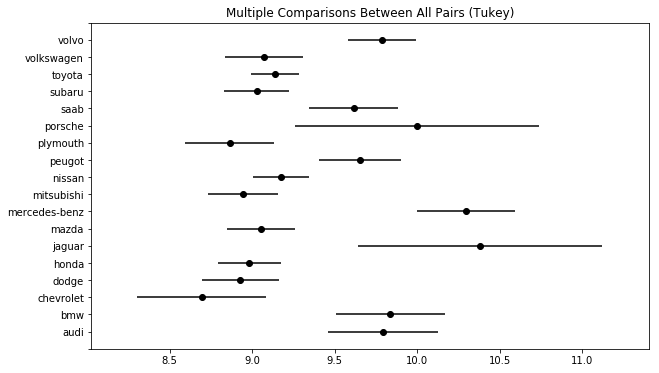

In [51]:
Tukey_make = pairwise_tukeyhsd(auto_price['log_price'], auto_price['make']) # fill in the parameters
print(Tukey_make)
Tukey_make.plot_simultaneous()

According Tukey test null hypotesis could be rejected for almost all pairs of makes.

## By Number of Doors ##

In [49]:
f_statistic, p_value = ss.f_oneway(two_doors, four_doors) # fill in parameters
print('F statistic = ' + str(f_statistic))
print('P-value = ' + str(p_value))

F statistic = 7.6476548772
P-value = 0.00636631623862


F-statistic is big, P-value is less than confidence level. There is a difference in price for autos stratified by number of doors, so we can reject the null hypotesis. 

In [53]:
Tukey_door = pairwise_tukeyhsd(auto_price['log_price'], auto_price['num-of-doors']) # fill in the parameters
print(Tukey_door)


Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
 four   two   -0.1938  -0.3322 -0.0554  True 
---------------------------------------------


According Tukey test null hypotesis could be rejected.

## By Fuel System ##

In [54]:
f_statistic, p_value = ss.f_oneway(mpfi, bbl2, idi, bbl1, spdi) # fill in parameters
print('F statistic = ' + str(f_statistic))
print('P-value = ' + str(p_value))

F statistic = 46.5771070118
P-value = 1.48566619217e-25


F-statistic is big, P-value is less than confidence level. There is a difference in price for autos stratified by fuel system, so we can reject the null hypotesis. 

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
 1bbl   2bbl  -0.0169  -0.3013  0.2676 False 
 1bbl   idi    0.6334   0.2879  0.979   True 
 1bbl   mfi    0.5549  -0.3543  1.4641 False 
 1bbl   mpfi   0.6527   0.3685  0.9368  True 
 1bbl   spdi   0.1663  -0.3032  0.6358 False 
 2bbl   idi    0.6503   0.4002  0.9004  True 
 2bbl   mfi    0.5718  -0.3056  1.4491 False 
 2bbl   mpfi   0.6695   0.515   0.824   True 
 2bbl   spdi   0.1831  -0.2213  0.5876 False 
 idi    mfi   -0.0785  -0.9776  0.8205 False 
 idi    mpfi   0.0193  -0.2305  0.269  False 
 idi    spdi  -0.4671  -0.9166 -0.0176  True 
 mfi    mpfi   0.0978  -0.7795  0.975  False 
 mfi    spdi  -0.3886  -1.3422  0.565  False 
 mpfi   spdi  -0.4864  -0.8906 -0.0822  True 
---------------------------------------------


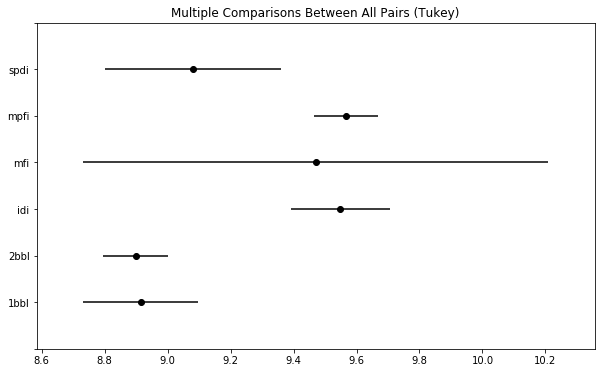

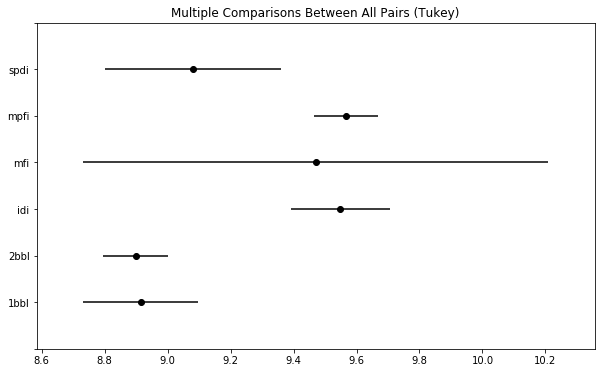

In [67]:
Tukey_fuel = pairwise_tukeyhsd(auto_price['log_price'], auto_price['fuel-system']) # fill in the parameters
print(Tukey_fuel)
Tukey_fuel.plot_simultaneous()

According Tukey test null hypotesis is rejected for pairs:
* 1bbl and idi;
* 1bbl and mpfi;
* 2bbl and idi;
* 2bbl and mpfi;
* idi and spdi;
* mpfi and spdi.

## SUMMARY ##

In Assignment #4:
1. Normality the distributions of price and log price  was tested  using Q-Q plot test and double-sided t-test.
According these test distributions both aren't normal, but log_price is more likely "normal" than price.
2. Significances of price stratified by a) fuel type, b) aspiration, and c) rear vs. front wheel drive were tested.
3. ANOVA and Tukey's HSD test were applied to test differences between the log_price conditioned by body-style. They've shown that there is a difference between different body-styles of autos. 
4. The differences between the log_price conditioned by make, num of doors and fuel system were shown using box-plots.
5. ANOVA and Tukey's HSD test were applied to test differences between the log_price conditioned by make, num of doors and fuel system. They've shown that there is a difference between different categories for each variable.